# Climate model: Estimated CO2 emissions from food consumption


We model the impact of diet changes on CO2 based on CO2 estimates for modeled vegan, vegetarian, and average meat eater diets from U.S. based LCA studies.

We start from a baseline based on individuals' average diets, averaged over the population.

To compute this baseline, we use survey data reporting on the number of days per week people eat vegan, vegetarian, vs meat diets. We match the survey data with census data to construct a representative sample of the MA population from which to draw the diet information.

The output of this is:

M = number of days/week average person eats meat
V = number of days/week average person eats a vegetarian diet 
PB = number of days/week average person eats a plant-based (vegan) diet


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Codebook

A map of values from the Qualtrics survey (subset to questions used in this analysis).

In [2]:
# This is a dump from the recode values exported from qualtrics Q_US_state.
# Qualtrics put the states in alphabetical order for their recode value, did not code by FIPs
states_recode_text = '1\nAlabama\n2\nAlaska\n3\nArizona\n4\nArkansas\n5\nCalifornia\n6\nColorado\n7\nConnecticut\n8\nDelaware\n9\nDistrict of Columbia\n10\nFlorida\n11\nGeorgia\n12\nHawaii\n13\nIdaho\n14\nIllinois\n15\nIndiana\n16\nIowa\n17\nKansas\n18\nKentucky\n19\nLouisiana\n20\nMaine\n21\nMaryland\n22\nMassachusetts\n23\nMichigan\n24\nMinnesota\n25\nMississippi\n26\nMissouri\n27\nMontana\n28\nNebraska\n29\nNevada\n30\nNew Hampshire\n31\nNew Jersey\n32\nNew Mexico\n33\nNew York\n34\nNorth Carolina\n35\nNorth Dakota\n36\nOhio\n37\nOklahoma\n38\nOregon\n39\nPennsylvania\n40\nPuerto Rico\n41\nRhode Island\n42\nSouth Carolina\n43\nSouth Dakota\n44\nTennessee\n45\nTexas\n46\nUtah\n47\nVermont\n48\nVirginia\n49\nWashington\n50\nWest Virginia\n51\nWisconsin\n52\nWyoming\n53\nI do not reside in the United States'
states_recode_list = states_recode_text.split('\n')
states_choices_map = {states_recode_list[i]: states_recode_list[i+1] for i in range(0, len(states_recode_list), 2)}
# states_choices_map

In [3]:
# {QID: {Q: Q text, choices: map}}
codebook = {
    'Q_special_diet':{
        'Q': 'Are you on any special diet? (select all that apply)',
        'choices': {
            '1':'Keto','2':'Pescatarian','3':'Vegetarian',
            '4':'Gluten free','5':'Vegan','6':'Other','7':'None'
        },
    },
    # call this question Q.1
    'Q_past_vegetarian': {
        'Q':'In the past 7 days, on how many days did you have a meal that contained any meat, poultry, or fish?',
        'choices': {
            '7': 7,
            '6': 6,
            '5': 5,
            '4': 4,
            '3': 3,
            '2': 2,
            '1': 1,
            '0': 0,
        },
    },
    # call this question Q.2
    'Q_past_vegan': {
        'Q':'In the past 7 days, on how many days did you eat a meal that contained any kind of animal product? (i.e. on how many days did you eat meat, poultry, fish, dairy, eggs, etc?)',
        'choices': {
            '7': 7,
            '6': 6,
            '5': 5,
            '4': 4,
            '3': 3,
            '2': 2,
            '1': 1,
            '0': 0,
        },
    },
    'Q_good_for_env': {
        'Q':'How strongly do you agree with the following statement?\n"Vegetarian and vegan dishes are good for the environment."',
        'choices': {
            '1':'Strongly agree','2':'Agree','3':'Neutral',
            '4':'Disagree','5':'Strongly disagree'
        },
    },
    'Q_politics': {
        'Q':'Which of the following best describes your political preference?',
        'choices': {
            '1':'Strongly Democratic','2':'Democratic',
            '3':'Lean Democratic','4':'Lean Republican','5':'Republican','6':'Strongly Republican'
        }
    },
    'Q_demos_gender': {
        'Q':'What is your gender?',
        'choices': {'1':'Male','2':'Female','3':'Other', '4':'Prefer not to answer'},
    },
    'Q_demos_age': {
        'Q': 'How old are you?',
        'choices': {
            '1':'Under 18', # should have none!
            '2':'18 - 24 years old',
            '3':'25 - 34 years old',
            '4':'35 - 44 years old',
            '5':'45 - 54 years old',
            '6':'55 - 64 years old',
            '7':'65+ years old'
        },
    },
    'Q_demos_income': {
        'Q': 'What was your total household income before taxes during the past 12 months?',
        'choices': {
            '1':'Less than \$25,000','2':'\$25,000 to \$49,999',
            '3':'\$50,000 to $74,999','4':'\$75,000 to \$99,999',
            '5':'\$100,000 to $149,999','6':'\$150,000 or more',
            '7':'Prefer not to say',
        },
    },
    'Q_demos_race': {
        'Q': 'Choose one or more races that you consider yourself to be',
        'choices': {
            '1':'White or Caucausian',
            '2':'Black or African American',
            '3':'American Indian/Native American or Alaska Native',
            '4':'Asian',
            '5':'Native Hawaiian or Other Pacific Islander',
            '6':'Other',
            '7':'Prefer not to say'
        },
    },
    'Q_US_state': {
        'Q':'In which state do you currently reside?',
        'choices': states_choices_map,
    },
}

## Census data

We use 2020 ACS 5-Year Estimates (Table DP05) for the MA population. 

We use population numbers by age group reported by the 2020 ACS 5-Year (Table DP05) for the MA population. This survey does not report gender split by age group, but does report an overall male/female gender split near 50/50 (51.5 total population is female). We assume a 50/50 gender split for each age group.
We use stratified random sampling, with replacement, to construct a sample that represents the MA population with respect to age and gender: For each age group we randomly draw (with replacement) samples from our survey data for participants reporting gender as male until 50% of the age group population is reached (relative to the total sampled population), and then repeat this for female participants.


#### Note the limitation:

Our survey data is limited to people 18 years or older, so our representative sample represents the MA population 18 years or older.

We match the ACS age group 20-24 to our survey 18-24 age group.


The following codes are pulled from the ACSDP5Y2020.DP05_metadata file.
```
DP05_0009PE	Percent!!SEX AND AGE!!Total population!!20 to 24 years
DP05_0010PE	Percent!!SEX AND AGE!!Total population!!25 to 34 years
DP05_0011PE	Percent!!SEX AND AGE!!Total population!!35 to 44 years
DP05_0012PE	Percent!!SEX AND AGE!!Total population!!45 to 54 years
DP05_0013PE	Percent!!SEX AND AGE!!Total population!!55 to 59 years
DP05_0014PE	Percent!!SEX AND AGE!!Total population!!60 to 64 years
DP05_0015PE	Percent!!SEX AND AGE!!Total population!!65 to 74 years
DP05_0016PE	Percent!!SEX AND AGE!!Total population!!75 to 84 years
DP05_0017PE	Percent!!SEX AND AGE!!Total population!!85 years and over
```

In [4]:
acs_df = pd.read_csv(
    '../data/ACSDP5Y2020.DP05_data_with_overlays.csv',
    usecols=[
        'DP05_0009PE','DP05_0010PE','DP05_0011PE','DP05_0012PE','DP05_0013PE',
        'DP05_0014PE','DP05_0015PE','DP05_0016PE','DP05_0017PE'
    ],
).rename({1:'percent total population'}).drop([0]).astype(float)
acs_df

,DP05_0009PE,DP05_0010PE,DP05_0011PE,DP05_0012PE,DP05_0013PE,DP05_0014PE,DP05_0015PE,DP05_0016PE,DP05_0017PE
percent total population,7.1,14.3,12.2,13.3,7.1,6.5,9.5,4.6,2.4


In [5]:
"""
Make a dataframe with columns for age groups matching our survey data.
Collapse ACS columns into larger groups.
"""
acs_df = pd.DataFrame({
    '18 - 24 years old': acs_df['DP05_0009PE'],
    '25 - 34 years old': acs_df['DP05_0010PE'],
    '35 - 44 years old': acs_df['DP05_0011PE'],
    '45 - 54 years old': acs_df['DP05_0012PE'],
    '55 - 64 years old': acs_df['DP05_0013PE'] + acs_df['DP05_0014PE'],
    '65+ years old':  acs_df['DP05_0015PE'] + acs_df['DP05_0016PE'] + acs_df['DP05_0017PE'],
})
# Note the percentages should not sum to 100 since they only represent adult population
print('sums to %s' % sum(acs_df.transpose()['percent total population']))
acs_df.transpose()

sums to 77.0


,percent total population
18 - 24 years old,7.1
25 - 34 years old,14.3
35 - 44 years old,12.2
45 - 54 years old,13.3
55 - 64 years old,13.6
65+ years old,16.5


## Survey data

The survey data was implemented using Qualtrics and data was collected via Prolific June - July 2022. The survey was limited to participants on the Prolific platform that said they lived in a U.S. state within New England (MA/NH/CT/RI/VT/ME) and that English is their first language when they signed up as participants. We then limit data used to participants who said they currently live within MA when completing the survey.

Survey data collected

Demographic:
- Gender (male/female/other/prefer not to say; only male/female is used)
- Age group
- Income group (used just for data checks)
- Current U.S. state of residence

Diet questions:
- Number of days in past week ate meat/poultry/fish (0-7)
- Number of days in past week ate any animal product: meat/poultry/fish/dairy/eggs, etc (0-7)


In [6]:
# extract relevant columns
sample_df = pd.read_csv(
    '../data/online-v1-prolific-sample.csv',
    usecols=[
        'PROLIFIC_PID', # embedded variable set through URL params
        'RecordedDate', 'ResponseId',
        'Q_attn_1', 'Q_attn_2', 'Q_attn_check', 'Q_attn_midway', 
        'Q_US_state',
        'Q_special_diet',
        'Q_past_vegetarian', 'Q_past_vegan', 
        'Q_good_for_env', 'Q_politics',
        'Q_demos_age', 'Q_demos_gender', 'Q_demos_income', 'Q_demos_race',
]).drop([0,1])
sample_df.head(3)

,RecordedDate,ResponseId,Q_attn_1,Q_attn_2,Q_attn_check,Q_special_diet,Q_past_vegetarian,Q_past_vegan,Q_good_for_env,Q_attn_midway,Q_politics,Q_US_state,Q_demos_age,Q_demos_gender,Q_demos_income,Q_demos_race,PROLIFIC_PID
2,2022-06-28 09:32:52,R_125SdSXI0xLI29S,21,5,"1,2",7,7,7,2,5,3,22,4,1,6,1,5ae11f9709eae20001132c22
3,2022-06-28 09:34:23,R_23V4Eyckqxl6Bmy,21,5,"1,2",7,4,6,2,5,3,22,7,1,5,1,5dd311bde25acf3254f36c9c
4,2022-06-28 09:35:35,R_2c5wLF9HxTeZ30h,21,5,"1,2",7,3,3,1,5,1,20,5,2,2,1,5ba3e40d2d28760001a377bb


### Survey data filtering
- We limit data to participants who report living in MA.
- We drop data from participants who failed any of the attention checks in the survey.
- We drop data from participants who answer a higher number for Diet Q.1 than Diet Q.2 (see above) because these answers are then inconsistent; they might not have understood the question.
- We drop data from participants who did not answer the gender question as male/female (i.e. drop people who reported "other" or "prefer not to say") in order to better match census data.


In [7]:
# only include completed surveys via Prolific
N_PROLIFIC_PID_na = len(sample_df[sample_df['PROLIFIC_PID'].isna()])
print('dropping %s non PROLIFIC responses' % N_PROLIFIC_PID_na)
sample_df = sample_df[sample_df['PROLIFIC_PID'].notna()]

dropping 1 non PROLIFIC responses


In [8]:
def passed_attn_checks(row):
    if not ((row['Q_attn_1'] == 'twenty one') or (int(row['Q_attn_1']) == 21)):
        print(row['ResponseId'], 'failed Q_attn_1')
        return False
    if int(row['Q_attn_2']) != 5:
        print(row['ResponseId'], 'failed Q_attn_2')
        return False
    if row['Q_attn_check'] != '1,2':
        print(row['ResponseId'], 'failed Q_attn_check')
        return False
    if int(row['Q_attn_midway']) != 5:
        print(row['ResponseId'], 'failed Q_attn_midway')
        return False
    return True

In [9]:
sample_df['passed_attn_checks'] = sample_df.apply(passed_attn_checks, axis=1)
passed_attn_checks_id_list = list(sample_df[sample_df.passed_attn_checks == True].ResponseId)
print('%s/%s respondents passed all attention checks' % (len(passed_attn_checks_id_list), len(sample_df)))
# passed_attn_checks_id_list

R_1Nagt8YYb9KXsgu failed Q_attn_check
R_25u12nxsbq17quY failed Q_attn_2
R_1ewLnYbEh64px5y failed Q_attn_2
R_3EbCFbWypJAH9eU failed Q_attn_2
R_31sGHSw29sejYZu failed Q_attn_check
R_XNtU8UZMHfqK8lX failed Q_attn_2
R_1Ov4PG2EqkoaNBI failed Q_attn_2
R_2sbRJWBoxeF0yHs failed Q_attn_2
R_3Hho2J2KAXLsDob failed Q_attn_2
R_3HUPi75tTdT9pnD failed Q_attn_2
R_1eLSotOLp5DjqJP failed Q_attn_2
R_1LLnNW2RfOKf93z failed Q_attn_midway
R_3fvnmHGH7Bmp938 failed Q_attn_2
R_33mAmfZaIBDBZiT failed Q_attn_2
R_3g8l72aZYNXtcZh failed Q_attn_check
R_1CjxgolIeuRdypP failed Q_attn_check
R_UDAbbOpDeLg8Jot failed Q_attn_check
R_1HqLpaBDw6P827V failed Q_attn_2
R_pR8DHCNXAHa8ZFv failed Q_attn_2
R_ahgvJfr1UphyDap failed Q_attn_check
R_1GVKbaKQiuw141N failed Q_attn_2
R_3Lcik6s2LGNYWgX failed Q_attn_check
R_3lDnbCj1Va514U1 failed Q_attn_midway
604/627 respondents passed all attention checks


Drop responses from participants who failed ANY attention check

In [10]:
print('dropping responses from participants who failed any attention check')
sample_df = sample_df[sample_df['passed_attn_checks']]

dropping responses from participants who failed any attention check


In which state do you currently reside?



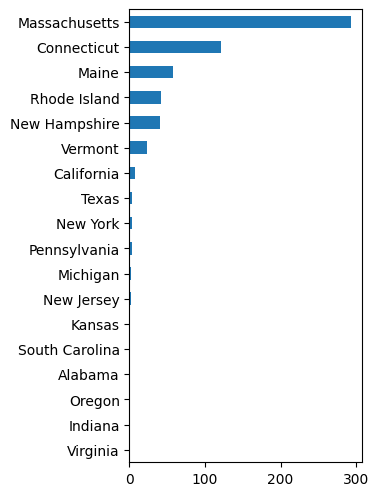

In [11]:
# Participation by state
print('%s\n'%codebook['Q_US_state']['Q'])
fig,ax = plt.subplots(figsize=(3,6), dpi=100)
_ = sample_df['Q_US_state'].value_counts().sort_values().rename(
    codebook['Q_US_state']['choices']).plot.barh(ax=ax)

Drop responses from people outside MA

In [12]:
n_all_states = len(sample_df)
sample_df = sample_df[sample_df['Q_US_state'].map(codebook['Q_US_state']['choices']) == 'Massachusetts']
n_ma = len(sample_df)
print('limiting sample data to %s participants residing in MA (out of %s total)' % (n_ma, n_all_states))

limiting sample data to 293 participants residing in MA (out of 604 total)


We drop data from participants who answer a higher number for Diet Q.1 than Diet Q.2 (see above) because these answers are then inconsistent; they might not have understood the question.

In [13]:
# Note the names of these columns are the opposite of what they ask about
print('dropping data from %s participants with inconsistent diet answers' % (
    sum(sample_df['Q_past_vegetarian'] > sample_df['Q_past_vegan'])
))
sample_df = sample_df[sample_df['Q_past_vegetarian'] <= sample_df['Q_past_vegan']]

dropping data from 9 participants with inconsistent diet answers


We drop data from participants who did not answer the gender question as male/female (i.e. drop people who reported "other" or "prefer not to say") in order to better match census data.

What is your gender?

Prefer not to answer      1
Other                    10
Male                    104
Female                  169
Name: Q_demos_gender, dtype: int64


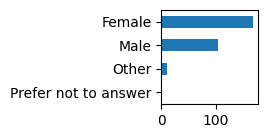

In [14]:
# Participation by gender
print('%s\n'%codebook['Q_demos_gender']['Q'])
fig,ax = plt.subplots(figsize=(1.25,1.25), dpi=100)
print(sample_df['Q_demos_gender'].value_counts().sort_values().rename(
    codebook['Q_demos_gender']['choices']))
_ = sample_df['Q_demos_gender'].value_counts().sort_values().rename(
    codebook['Q_demos_gender']['choices']).plot.barh(ax=ax)

In [15]:
print('dropping data from %s participants who did not answer with a Male/Female gender identity' % (
    (len(sample_df) - sum(sample_df['Q_demos_gender'].isin(['1','2'])))
))
sample_df = sample_df[sample_df['Q_demos_gender'].isin(['1','2'])]

dropping data from 11 participants who did not answer with a Male/Female gender identity


In [16]:
print('resulting sample size: %s' % len(sample_df))

resulting sample size: 273


### Sample demographics / sample data representativeness

Inspect demographics before creating representative sample.

How old are you?


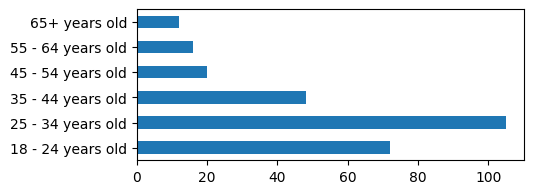

In [17]:
print('%s'%codebook['Q_demos_age']['Q'])
fig,ax = plt.subplots(figsize=(5,2), dpi=100)
_ = sample_df['Q_demos_age'].value_counts().rename(codebook['Q_demos_age']['choices']).sort_index().plot.barh(ax=ax)
# print(sample_df['Q_demos_age'].value_counts().sort_index().rename(codebook['Q_demos_age']['choices']))

What was your total household income before taxes during the past 12 months?



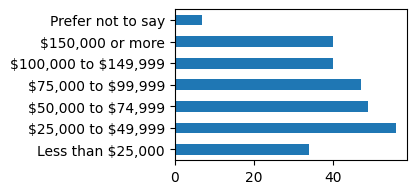

In [18]:
print('%s\n'%codebook['Q_demos_income']['Q'])
fig,ax = plt.subplots(figsize=(3,2), dpi=100)
_ = sample_df['Q_demos_income'].value_counts().sort_index().rename(
    codebook['Q_demos_income']['choices']).plot.barh(ax=ax)
# print(sample_df['Q_demos_income'].value_counts().sort_index())

Choose one or more races that you consider yourself to be


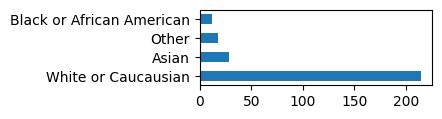

In [19]:
# Race: We put anyone who answered with 2 or more races or 'Prefer not to say' 
# in the 'Other' category
# print(sample_df['Q_demos_race'].value_counts())
sample_df['race'] = (sample_df['Q_demos_race']
                       .apply(lambda r: r if r in ['1','2','3','4','5'] else '6')
                       .map(codebook['Q_demos_race']['choices']))
# print(sample_df['race'].value_counts())
print(codebook['Q_demos_race']['Q'])
fig,ax = plt.subplots(figsize=(3,1), dpi=100)
_ = sample_df['race'].value_counts().plot.barh(ax=ax)

Which of the following best describes your political preference?


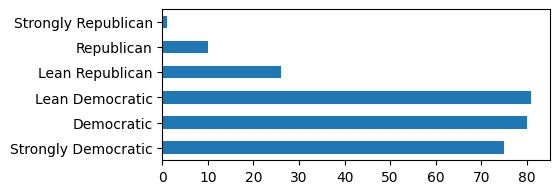

In [20]:
print(codebook['Q_politics']['Q'])
fig,ax = plt.subplots(figsize=(5,2), dpi=100)
_ = sample_df.Q_politics.value_counts().sort_index().rename(
    codebook['Q_politics']['choices']).plot.barh(ax=ax)
# print(sample_df['Q_politics'].value_counts().sort_index().rename(codebook['Q_politics']['choices']))

### Data transformations

#### Vegetarian and vegan diets

In [21]:
sample_df['Q_special_diet'].value_counts()

7        219
3         17
6         16
2          5
1          4
5          4
4          2
4,6        2
2,3        1
3,6        1
1,7        1
1,3,4      1
Name: Q_special_diet, dtype: int64

In [22]:
sample_df['is_vegetarian'] = sample_df['Q_special_diet'].astype(str).apply(lambda d: 1 if ('3' in d) else 0)
sample_df['is_vegan'] = sample_df['Q_special_diet'].astype(str).apply(lambda d: 1 if ('5' in d) else 0)

#### Past days eating meat, vegetarian, vegan

Note the questions `Q_past_vegetarian` and `Q_past_vegan` have counterintuitive IDs. They ask about number of days in the past week eating meat (`Q_past_vegetarian`) and any animal product (`Q_past_vegan`). 

We transform the responses for `Q_past_vegetarian` and `Q_past_vegan` into past days eating meat, vegetarian, vegan (plant-based) diets, coded as `M`,`V`,`PB`, respectively.

For each sample in the population we calculate their individual V: number of days per week eating vegetarian as 

`M = Q_past_vegetarian`

`V = Q_past_vegan - Q_past_vegetarian`

`PB = 7 - Q_past_vegan`

We then calculate averages over the population

In the past 7 days, on how many days did you have a meal that contained any meat, poultry, or fish?
In the past 7 days, on how many days did you eat a meal that contained any kind of animal product? (i.e. on how many days did you eat meat, poultry, fish, dairy, eggs, etc?)


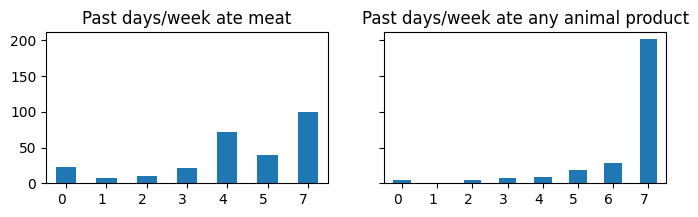

In [23]:
print(codebook['Q_past_vegetarian']['Q'])
print(codebook['Q_past_vegan']['Q'])
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(8,2), sharey=True, dpi=100)
ax1.set_title('Past days/week ate meat')
_ = sample_df['Q_past_vegetarian'].value_counts().sort_index().plot.bar(ax=ax1)
ax2.set_title('Past days/week ate any animal product')
_ = sample_df['Q_past_vegan'].value_counts().sort_index().plot.bar(ax=ax2)
_ = [ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='right') for ax in (ax1,ax2)]

In [24]:
sample_df['M'] = sample_df['Q_past_vegetarian'].astype(int)
sample_df['V'] = sample_df['Q_past_vegan'].astype(int) - sample_df['Q_past_vegetarian'].astype(int)
sample_df['PB'] = 7 - sample_df['Q_past_vegan'].astype(int)

Some basic column name transformations

In [25]:
sample_df['age'] = sample_df['Q_demos_age'].map(codebook['Q_demos_age']['choices'])
sample_df['gender'] = sample_df['Q_demos_gender'].map(codebook['Q_demos_gender']['choices'])
sample_df.head()

,RecordedDate,ResponseId,Q_attn_1,Q_attn_2,Q_attn_check,Q_special_diet,Q_past_vegetarian,Q_past_vegan,Q_good_for_env,Q_attn_midway,...,PROLIFIC_PID,passed_attn_checks,race,is_vegetarian,is_vegan,M,V,PB,age,gender
2,2022-06-28 09:32:52,R_125SdSXI0xLI29S,21,5,"1,2",7,7,7,2,5,...,5ae11f9709eae20001132c22,True,White or Caucausian,0,0,7,0,0,35 - 44 years old,Male
3,2022-06-28 09:34:23,R_23V4Eyckqxl6Bmy,21,5,"1,2",7,4,6,2,5,...,5dd311bde25acf3254f36c9c,True,White or Caucausian,0,0,4,2,1,65+ years old,Male
11,2022-06-28 09:42:26,R_WCLrlRwRPRa5O6J,21,5,"1,2",7,4,6,2,5,...,5f49f3262a3d07563d14a7f1,True,White or Caucausian,0,0,4,2,1,25 - 34 years old,Male
12,2022-06-28 09:42:50,R_yxyjdMYFT14xiN3,21,5,"1,2",7,5,7,2,5,...,6294ea877522945ad8df1578,True,White or Caucausian,0,0,5,2,0,35 - 44 years old,Male
13,2022-06-28 09:42:57,R_2xL9vHDm0KfOgCa,21,5,"1,2",7,7,7,2,5,...,6294fc5023a8698296cbf7b0,True,Asian,0,0,7,0,0,18 - 24 years old,Male


### Stratified random sampling to create a 'representative' sample population for MA

We use population numbers by age group reported by the 2020 ACS 5-Year (Table DP05) for the MA population. This survey does not report gender split by age group, but does report an overall male/female gender split near 50/50. We assume a 50/50 gender split for each age group.
We use stratified random sampling, with replacement, to construct a sample that represents the MA population with respect to age and gender: For each age group we randomly draw (with replacement) samples from our survey data for participants reporting gender as male until 50% of the age group population is reached, and then repeat this for female participants.


In [26]:
acs_df

,18 - 24 years old,25 - 34 years old,35 - 44 years old,45 - 54 years old,55 - 64 years old,65+ years old
percent total population,7.1,14.3,12.2,13.3,13.6,16.5


In [27]:
# only sample the columns we're interested in. Drop the others.
sampling_frame_df = sample_df[[
    'age', 'gender', 'Q_demos_income', 'race',
    'Q_good_for_env', 'Q_politics',
    'M', 'V', 'PB',
    'is_vegetarian', 'is_vegan',
]]

In [28]:
# Fake MA population N
N_ma_sample_pop = 1000
random_state = N_ma_sample_pop # used to ensure reproducibility 

ma_stratified_df = pd.DataFrame(columns=sampling_frame_df.columns)

for age_group in acs_df.columns:
    print('age group: %s; ACS estimated pct = %s' % (age_group, acs_df[age_group].values[0]))
    # sample 50/50 male/female
    for gender in ['Male','Female']:
        strata_df = sampling_frame_df[(
            (sampling_frame_df['gender']==gender) & \
            (sampling_frame_df['age']==age_group)
        )]
        ma_stratified_df = pd.concat([
            ma_stratified_df, 
            strata_df.sample(
                n=round(N_ma_sample_pop*0.5*acs_df[age_group].values[0]),
                replace=True,
                random_state=random_state,
            )
        ])
# ma_stratified_df.head()

age group: 18 - 24 years old; ACS estimated pct = 7.1
age group: 25 - 34 years old; ACS estimated pct = 14.3
age group: 35 - 44 years old; ACS estimated pct = 12.2
age group: 45 - 54 years old; ACS estimated pct = 13.3
age group: 55 - 64 years old; ACS estimated pct = 13.6
age group: 65+ years old; ACS estimated pct = 16.5


In [29]:
# data checks
assert(len(ma_stratified_df) == N_ma_sample_pop*sum(acs_df.transpose()['percent total population']))
print(ma_stratified_df.groupby(['age']).count()['gender']/N_ma_sample_pop)
print(ma_stratified_df.groupby(['gender']).count()['age']/len(ma_stratified_df))

age
18 - 24 years old     7.1
25 - 34 years old    14.3
35 - 44 years old    12.2
45 - 54 years old    13.3
55 - 64 years old    13.6
65+ years old        16.5
Name: gender, dtype: float64
gender
Female    0.5
Male      0.5
Name: age, dtype: float64


### Population averages for M, V, PB


In [30]:
print('mean M = %0.2f'%ma_stratified_df['M'].mean())
print('mean V = %0.2f'%ma_stratified_df['V'].mean())
print('mean PB = %0.2f'%ma_stratified_df['PB'].mean())
# data check -- should sum to ~7 days per week
assert(7 == round(sum([ma_stratified_df[D].mean() for D in ['M','V','PB']])))

mean M = 4.46
mean V = 1.71
mean PB = 0.83


In [31]:
print('median M = %0.2f'%ma_stratified_df['M'].median())
print('median V = %0.2f'%ma_stratified_df['V'].median())
print('median PB = %0.2f'%ma_stratified_df['PB'].median())

median M = 4.00
median V = 2.00
median PB = 0.00


### More detailed breakdowns

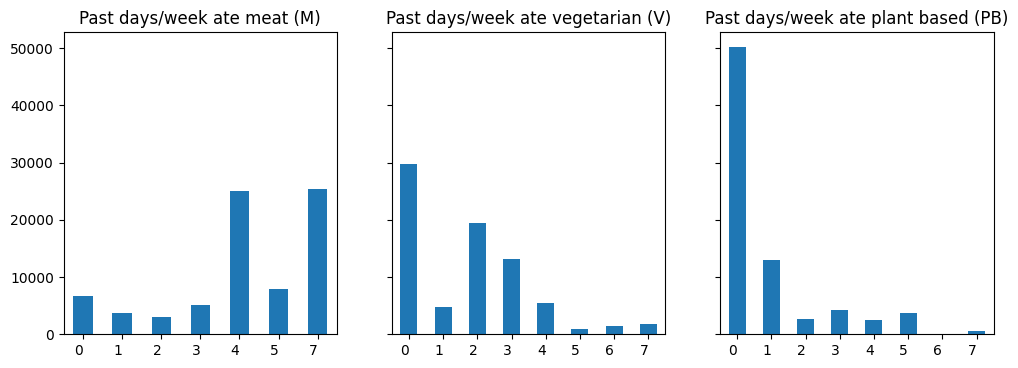

In [32]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,4), sharey=True, dpi=100)
ax1.set_title('Past days/week ate meat (M)')
_ = ma_stratified_df['M'].value_counts().sort_index().plot.bar(ax=ax1)
ax2.set_title('Past days/week ate vegetarian (V)')
_ = ma_stratified_df['V'].value_counts().sort_index().plot.bar(ax=ax2)
ax3.set_title('Past days/week ate plant based (PB)')
_ = ma_stratified_df['PB'].value_counts().sort_index().plot.bar(ax=ax3)
_ = [ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='right') for ax in (ax1,ax2,ax3)]

# print('Past days/week ate meat (M)')
# print(ma_stratified_df['M'].value_counts().sort_index())
# print(ma_stratified_df['M'].describe())
# print('\nPast days/week ate vegetarian (V)')
# print(ma_stratified_df['V'].value_counts().sort_index())
# print(ma_stratified_df['V'].describe())
# print('\nPast days/week ate plant based (PB)')
# print(ma_stratified_df['PB'].value_counts().sort_index())
# print(ma_stratified_df['PB'].describe())

In [33]:
ma_stratified_df.groupby(['age', 'gender']).agg({
    'M': ['mean', 'std', 'median'],
    'V': ['mean', 'std', 'median'],
    'PB': ['mean', 'std', 'median'],
})

M                          V            \
                              mean       std median      mean       std   
age               gender                                                  
18 - 24 years old Female  4.467042  2.229167    5.0  1.804507  1.825767   
                  Male    5.582254  2.007697    7.0  1.417746  2.007697   
25 - 34 years old Female  4.259860  2.523111    4.0  2.145315  2.304490   
                  Male    5.500559  1.614450    5.0  1.081818  1.478107   
35 - 44 years old Female  4.634262  1.964559    4.0  1.237541  1.390290   
                  Male    5.077869  1.670221    5.0  1.343443  1.339640   
45 - 54 years old Female  3.445865  2.346603    4.0  2.655338  1.922394   
                  Male    5.006617  1.572804    4.0  1.615188  1.395493   
55 - 64 years old Female  3.644118  2.325440    4.0  2.143088  2.123894   
                  Male    4.663088  1.097212    4.0  1.673235  0.739483   
65+ years old     Female  2.940364  2.720206    1.0  1.994424  1.571419   
                  Male    5.066909  1.961660    4.0  1.285091  1.475605   

                                       PB                   
                         median      mean       std median  
age               gender                                    
18 - 24 years old Female    2.0  0.728451  1.607448    0.0  
                  Male      0.0  0.000000  0.000000    0.0  
25 - 34 years old Female    2.0  0.594825  1.425308    0.0  
                  Male      0.0  0.417622  0.865155    0.0  
35 - 44 years old Female    1.0  1.128197  1.902603    0.0  
                  Male      1.0  0.578689  1.066046    0.0  
45 - 54 years old Female    2.0  0.898797  1.374241    0.0  
                  Male      2.0  0.378195  0.484973    0.0  
55 - 64 years old Female    3.0  1.212794  1.888068    0.0  
                  Male      2.0  0.663676  0.472486    1.0  
65+ years old     Female    1.0  2.065212  2.138578    3.0  
                  Male      1.0  0.648000  1.332647    0.0

In [34]:
def styled_boxplot(df, by, column=None, ax=None):
    df.boxplot(
        column=column,
        by=by, ax=ax,
        grid=False,
        showmeans=True,
        meanprops=dict(marker='D', markeredgecolor='black', markerfacecolor='firebrick'),
        boxprops=dict(linestyle='-', linewidth=1.5),
        flierprops=dict(linestyle='-', linewidth=1.5),
        medianprops=dict(linestyle='-', linewidth=2, color='firebrick'),
        whiskerprops=dict(linestyle='-', linewidth=1.5),
        capprops=dict(linestyle='-', linewidth=1.5),
        showfliers=False, rot=0
    ).get_figure().suptitle('') # remove title automatically added by pandas
    _ = ax.set_xlabel('')

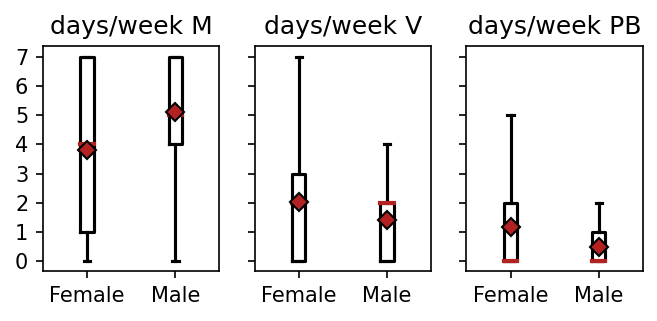

In [35]:
dpi = 150

fig,axes = plt.subplots(1,3, figsize=(5,2), dpi=dpi, sharey=True)
for i, (ax, d) in enumerate(zip(axes, ['M','V','PB'])):
    styled_boxplot(ma_stratified_df, column=d, by='gender', ax=ax)
    ax.set_title('days/week %s' % d)
    ax.set_yticks(list(range(8)))

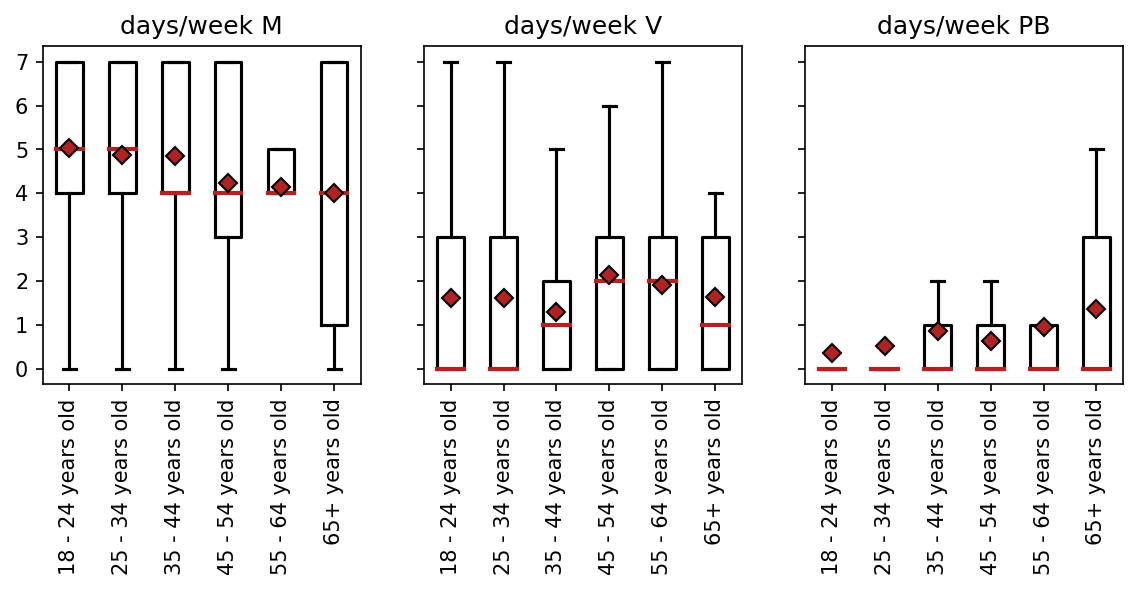

In [36]:
fig,axes = plt.subplots(1,3, figsize=(9,3), dpi=dpi, sharey=True)
for i, (ax, d) in enumerate(zip(axes, ['M','V','PB'])):
    styled_boxplot(ma_stratified_df, column=d, by='age', ax=ax)
    ax.set_title('days/week %s' % d)
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

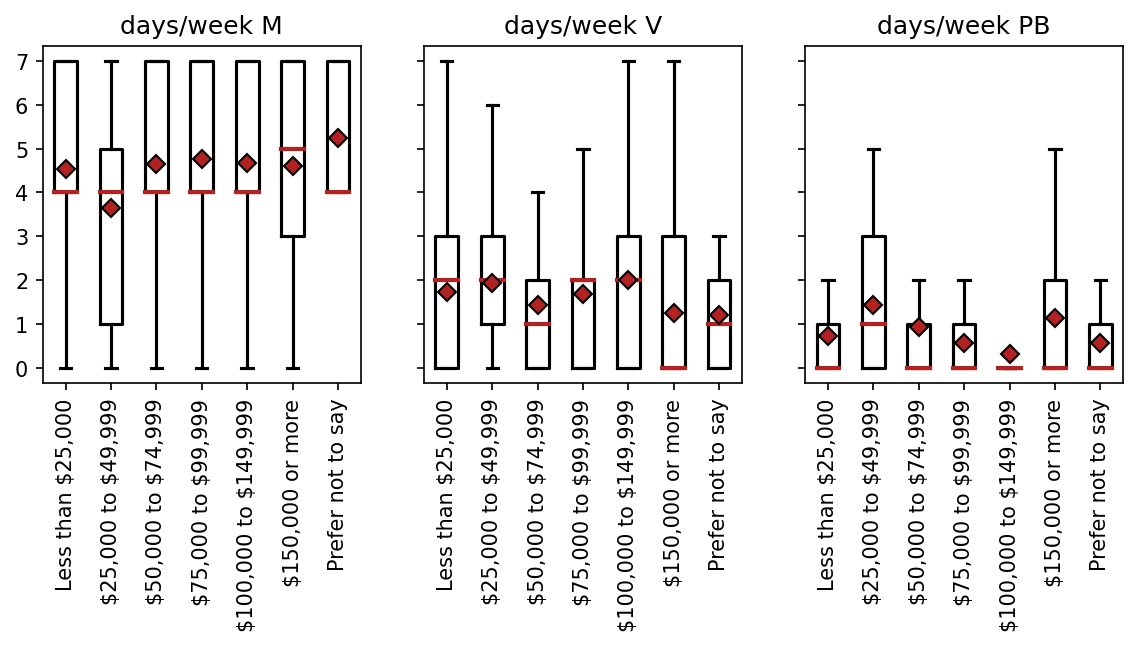

In [37]:
fig,axes = plt.subplots(1,3, figsize=(9,3), dpi=dpi, sharey=True)
for i, (ax, d) in enumerate(zip(axes, ['M','V','PB'])):
    styled_boxplot(ma_stratified_df, column=d, by='Q_demos_income', ax=ax)
    ax.set_title('days/week %s' % d)
    _ = ax.set_xticklabels(list(codebook['Q_demos_income']['choices'].values()),rotation=90)

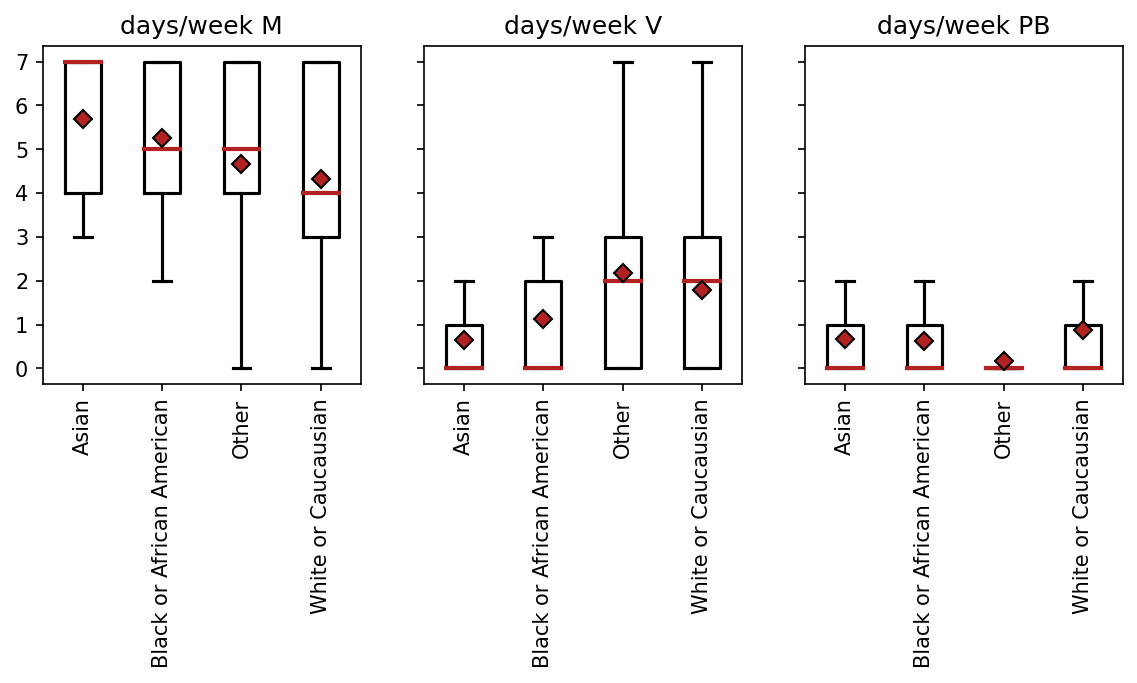

In [38]:
fig,axes = plt.subplots(1,3, figsize=(9,3), dpi=dpi, sharey=True)
for i, (ax, d) in enumerate(zip(axes, ['M','V','PB'])):
    styled_boxplot(ma_stratified_df, column=d, by='race', ax=ax)
    ax.set_title('days/week %s' % d)
    _ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

### Vegans and vegetarians by demographic group

In [39]:
is_v_by_age = ma_stratified_df.groupby('age')['is_vegetarian'].mean().round(3).rename('vegetarian').to_frame()
is_v_by_age['vegan'] = ma_stratified_df.groupby('age')['is_vegan'].mean().round(3)
is_v_by_age

,vegetarian,vegan
age,,
18 - 24 years old,0.058,0.021
25 - 34 years old,0.085,0.008
35 - 44 years old,0.024,0.022
45 - 54 years old,0.102,0.000
55 - 64 years old,0.104,0.000
65+ years old,0.000,0.000


In [40]:
is_v_by_income = ma_stratified_df.groupby('Q_demos_income')['is_vegetarian'].mean().round(3).rename('vegetarian').to_frame()
is_v_by_income['vegan'] = ma_stratified_df.groupby('Q_demos_income')['is_vegan'].mean().round(3)
is_v_by_income.rename(codebook['Q_demos_income']['choices'])

,vegetarian,vegan
Q_demos_income,,
"Less than \$25,000",0.090,0.000
"\$25,000 to \$49,999",0.088,0.000
"\$50,000 to $74,999",0.021,0.000
"\$75,000 to \$99,999",0.039,0.020
"\$100,000 to $149,999",0.051,0.007
"\$150,000 or more",0.112,0.020
Prefer not to say,0.000,0.000


In [41]:
is_v_by_gender = ma_stratified_df.groupby('gender')['is_vegetarian'].mean().round(3).rename('vegetarian').to_frame()
is_v_by_gender['vegan'] = ma_stratified_df.groupby('gender')['is_vegan'].mean().round(3)
is_v_by_gender

,vegetarian,vegan
gender,,
Female,0.087,0.014
Male,0.035,0.000


In [42]:
is_v_by_politics = ma_stratified_df.groupby('Q_politics')['is_vegetarian'].mean().round(3).rename('vegetarian').to_frame()
is_v_by_politics['vegan'] = ma_stratified_df.groupby('Q_politics')['is_vegan'].mean().round(3)
is_v_by_politics.rename(codebook['Q_politics']['choices'])

,vegetarian,vegan
Q_politics,,
Strongly Democratic,0.049,0.012
Democratic,0.085,0.016
Lean Democratic,0.068,0.000
Lean Republican,0.062,0.000
Republican,0.000,0.000
Strongly Republican,0.000,0.000


### Other

How strongly do you agree with the following statement?
"Vegetarian and vegan dishes are good for the environment."

Strongly agree       0.237338
Agree                0.536805
Neutral              0.181377
Disagree             0.028727
Strongly disagree    0.015753
Name: Q_good_for_env, dtype: float64


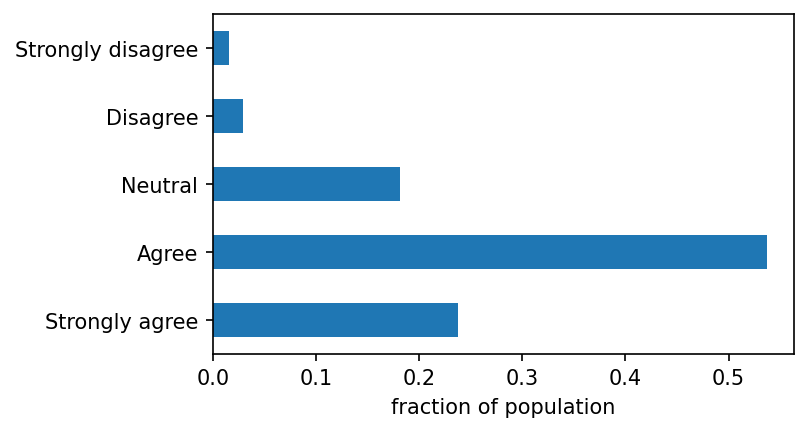

In [43]:
print('%s\n'%codebook['Q_good_for_env']['Q'])
fig,ax = plt.subplots(1,1,figsize=(5,3),dpi=150)
(ma_stratified_df['Q_good_for_env'].value_counts().sort_index().rename(
    codebook['Q_good_for_env']['choices']
)/len(ma_stratified_df)).plot.barh()
plt.xlabel('fraction of population')
print(ma_stratified_df['Q_good_for_env'].value_counts().sort_index().rename(
    codebook['Q_good_for_env']['choices']
)/len(ma_stratified_df))